<a href="https://colab.research.google.com/github/kaustavsen93/EMBA_Dynamic_Pricing/blob/main/Dynamic_Pricing_online.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
data_path =kagglehub.dataset_download("yasserh/instacart-online-grocery-basket-analysis-dataset")

print("Path to dataset files:", data_path)

Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset/versions/1


In [2]:
import pandas as pd
import numpy as np
import os

# Define data paths (replace with your actual paths if different)

orders_csv = os.path.join(data_path, "orders.csv")
order_products__prior_csv = os.path.join(data_path, "order_products__prior.csv")
order_products__train_csv = os.path.join(data_path, "order_products__train.csv")
products_csv = os.path.join(data_path, "products.csv")
departments_csv = os.path.join(data_path, "departments.csv")
aisles_csv = os.path.join(data_path, "aisles.csv")


# Load Data

orders = pd.read_csv(orders_csv)
order_products_prior = pd.read_csv(order_products__prior_csv)
order_products_train = pd.read_csv(order_products__train_csv)
products = pd.read_csv(products_csv)
departments = pd.read_csv(departments_csv)


In [3]:
# prompt: list the data in each dataframe

aisles = pd.read_csv(aisles_csv)

# Display the first few rows of each DataFrame
print("Orders DataFrame:")
print(orders.head())

print("\nOrder Products Prior DataFrame:")
print(order_products_prior.head())

print("\nOrder Products Train DataFrame:")
print(order_products_train.head())

print("\nProducts DataFrame:")
print(products.head())

print("\nDepartments DataFrame:")
print(departments.head())

print("\nAisles DataFrame:")
print(aisles.head())

Orders DataFrame:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

Order Products Prior DataFrame:
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5      

In [ ]:
import pandas as pd

# 1. Product Sales (as before)
product_sales = pd.concat([order_products_prior, order_products_train])
product_sales = product_sales.groupby('product_id').size().reset_index(name='product_total_orders')

products.drop(columns=['product_total_orders'], inplace=True, errors='ignore')
products = pd.merge(products, product_sales, on='product_id', how='left')


# 2. Order Time Features (as before)
orders['order_dow'] = orders['order_dow'].astype(int)
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype(int)
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0).astype(int)


# 3. Customer Behavior (RFM and more) - **Corrected**
# We now merge with 'orders' to get user_id

# Last Purchase Date
last_purchase_date = orders.groupby('user_id')['order_number'].max().reset_index()
last_purchase_date.rename(columns={'order_number': 'last_order_number'}, inplace=True)

# Purchase Frequency (Total Orders)
purchase_frequency = orders.groupby('user_id')['order_number'].count().reset_index()
purchase_frequency.rename(columns={'order_number': 'total_orders'}, inplace=True)


# Average Basket Size
average_basket_size = orders.groupby(['user_id', 'order_id']).size().reset_index(name='basket_size')
average_basket_size = average_basket_size.groupby('user_id')['basket_size'].mean().reset_index()
average_basket_size.rename(columns={'basket_size': 'avg_basket_size'}, inplace=True)

# Favorite Day of Week
favorite_day_of_week = orders.groupby('user_id')['order_dow'].agg(lambda x: x.mode()[0]).reset_index()
favorite_day_of_week.rename(columns={'order_dow': 'favorite_day_of_week'}, inplace=True)

all_orders = pd.merge(pd.concat([order_products_prior, order_products_train]), orders[['order_id', 'user_id']], on='order_id', how='left')

favorite_product = all_orders.groupby(['user_id', 'product_id']).size().reset_index(name='product_count')
favorite_product = favorite_product.loc[favorite_product.groupby('user_id')['product_count'].idxmax()]
favorite_product = favorite_product.drop(columns='product_count')
favorite_product = pd.merge(favorite_product, products[['product_id', 'product_name']], on='product_id', how='left',suffixes=('_original', ''))



# 4. Create Customers Dataframe
customers = pd.DataFrame({'user_id': orders['user_id'].unique()})

# Merging (as before)
customers = pd.merge(customers, last_purchase_date, on='user_id', how='left')
customers = pd.merge(customers, purchase_frequency, on='user_id', how='left')
customers = pd.merge(customers, average_basket_size, on='user_id', how='left')
customers = pd.merge(customers, favorite_day_of_week, on='user_id', how='left')
customers = pd.merge(customers, favorite_product, on='user_id', how='left')



print(customers.head())

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_sales_distribution(product_orders):
    plt.figure(figsize=(10, 5))
    plt.hist(product_orders['order_frequency'], bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Order Frequency')
    plt.xlabel('Order Frequency')
    plt.ylabel('Frequency')
    plt.show()

def plot_sales_trends_over_time(customer_behavior):
    sales_by_date = customer_behavior.groupby('order_dow')['order_frequency'].sum().reset_index()
    plt.figure(figsize=(12, 6))
    plt.plot(sales_by_date['order_dow'], sales_by_date['order_frequency'], color='blue', linewidth=2)
    plt.title('Order Trends Over Days of the Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Total Order Frequency')
    plt.show()

def plot_product_category_popularity(product_orders, products):
    product_category_sales = pd.merge(product_orders, products[['product_id', 'aisle_id']], on='product_id', how='left')
    product_category_sales = product_category_sales.groupby('aisle_id')['order_frequency'].sum().reset_index()
    product_category_sales = product_category_sales.sort_values('order_frequency', ascending=False)

    plt.figure(figsize=(14, 8))
    plt.barh(product_category_sales['aisle_id'][:20], product_category_sales['order_frequency'][:20], color='teal')
    plt.title('Top 20 Aisles by Order Frequency')
    plt.xlabel('Total Order Frequency')
    plt.ylabel('Aisle ID')
    plt.gca().invert_yaxis()
    plt.show()

def plot_customer_segmentation(customer_behavior):
    plt.figure(figsize=(8, 8))
    plt.scatter(customer_behavior['order_frequency'], customer_behavior['avg_basket_size'], s=50, alpha=0.7, color='purple')
    plt.title('Customer Segmentation (Frequency vs. Basket Size)')
    plt.xlabel('Order Frequency')
    plt.ylabel('Average Basket Size')
    plt.show()

def plot_avg_sales_per_day_of_week(customer_behavior):
    avg_sales_by_day = customer_behavior.groupby('order_dow')['avg_basket_size'].mean().reset_index()
    plt.figure(figsize=(8, 5))
    plt.bar(avg_sales_by_day['order_dow'], avg_sales_by_day['avg_basket_size'], color='orange', edgecolor='black')
    plt.title('Average Basket Size per Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Average Basket Size')
    plt.show()

def plot_distribution_of_purchase_frequency(customer_behavior):
    plt.figure(figsize=(10, 5))
    plt.hist(customer_behavior['order_frequency'], bins=50, color='green', edgecolor='black')
    plt.title('Distribution of Order Frequency')
    plt.xlabel('Order Frequency')
    plt.ylabel('Number of Customers')
    plt.show()

def plot_distribution_of_avg_basket_size(customer_behavior):
    plt.figure(figsize=(10, 5))
    plt.hist(customer_behavior['avg_basket_size'], bins=50, color='red', edgecolor='black')
    plt.title('Distribution of Average Basket Size per Customer')
    plt.xlabel('Average Basket Size')
    plt.ylabel('Number of Customers')
    plt.show()

# Example usage:
plot_sales_distribution(products)
plot_sales_trends_over_time(customers)
plot_product_category_popularity(product_orders, products)
plot_customer_segmentation(customer_behavior)
plot_avg_sales_per_day_of_week(customer_behavior)
plot_distribution_of_purchase_frequency(customer_behavior)

plot_distribution_of_avg_basket_size(customer_behavior)

KeyError: 'order_frequency'

<Figure size 1000x500 with 0 Axes>

In [5]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label


def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

In [6]:
#Sample a single product, day, and customer segment
cust_sample = customers.sample(1)
print(cust_sample)
product_id = cust_sample['product_id'].values[0]
day_of_week = cust_sample['favorite_day_of_week'].values[0]
#customer_segment = cust_sample['MARITAL_STATUS_CODE'].values[0]
user_id = cust_sample['user_id'].values[0]

customer_segment = "Unknown"

# Example using 'total_orders' for segmentation (adapt as needed):
if cust_sample['total_orders'].values[0] > customers['total_orders'].median():
    customer_segment = "Frequent Buyer"
else:
    customer_segment = "Infrequent Buyer"

print(f"Sampled Customer:")
print(f"  User ID: {user_id}")
print(f"  Favorite Product ID: {product_id}")
print(f"  Favorite Day of Week: {day_of_week}")
print(f"  Customer Segment: {customer_segment}")

      user_id  last_order_number  total_orders  avg_basket_size  \
7580     7581                 28            28              1.0   

      favorite_day_of_week  product_id product_name  
7580                     4       26209        Limes  
Sampled Customer:
  User ID: 7581
  Favorite Product ID: 26209
  Favorite Day of Week: 4
  Customer Segment: Frequent Buyer


In [7]:
import pandas as pd
import numpy as np

# ... (Your existing code for data preparation) ...

def demand_function(price, product_id, week_no, day_of_week, customer_segment, product_total_orders):
    """Predicts demand based on price and other features."""
    # Use product_total_orders instead of average weekly sales
    base_demand = product_total_orders
    price_sensitivity = -0.5
    segment_multiplier = 1

    if customer_segment == "A":  # Assuming customer segments are categorical
        segment_multiplier = 0.8
    elif customer_segment == "U": # Example customer segment
        segment_multiplier = 1.2

    demand = base_demand + price_sensitivity * price * segment_multiplier

    # Seasonality and weekend effects (as before)
    if week_no in range(20, 30):
        demand *= 1.2
    if day_of_week >= 5:
        demand *= 1.1

    return max(0, demand)


def profit_response(prices, orders_df, products_df, customers_df, unit_cost=0.5):
    """Calculates total profit for a given price schedule and user/product."""
    total_profit = 0

    user_orders = orders_df[orders_df['user_id'] == user_id].sort_values('order_number')
    customer_segment = customers_df[customers_df['user_id'] == user_id]['favorite_day_of_week'].iloc[0]
    product_total_orders = products_df[products_df['product_id'] == product_id]['product_total_orders'].iloc[0]



    for order_number, order_data in user_orders.iterrows():
         # Ensure prices is accessible by index corresponding to order_number.
         # Consider using a dictionary or other mapping if necessary.
        price_t = prices[order_number] if order_number < len(prices) else prices[-1] # Use last price if beyond the provided schedule


        week_no = order_data['order_number']  # Assuming each order corresponds to a week
        day_of_week = order_data['order_dow']



        demand_t = demand_function(price_t, product_id, week_no, day_of_week, customer_segment, product_total_orders)
        profit_t = (price_t - unit_cost) * demand_t
        total_profit += profit_t

    return total_profit




#profit = profit_response(prices,product_id, user_id, orders, products, customers)
#print(f"Profit for product {product_id} and user {user_id}: {profit}")

In [8]:
import pandas as pd
import numpy as np

# ... (Your existing data preparation and profit_response function) ...

def find_optimal_constant_price(price_grid, orders_df, products_df, customers_df):
    """Find the optimal constant price for a given product and user."""
    profits = []
    for p in price_grid:
        prices = np.repeat(p, len(orders_df[orders_df['user_id'] == user_id])) # Price array matching user's order history length.
        profit = profit_response(prices, orders_df, products_df, customers_df)
        profits.append(profit)

    profits = np.array(profits)
    optimal_price = price_grid[np.argmax(profits)]
    max_profit = np.max(profits)

    return optimal_price, max_profit


# Example usage:
price_grid = np.linspace(0.5, 5.0, 10)


price_opt_const, max_profit = find_optimal_constant_price(price_grid,orders, products, customers)


# Print results
print(f"Optimal constant price is {price_opt_const}, achieved profit is {max_profit}")


Optimal constant price is 5.0, achieved profit is 20379526.200000003


Optimal price schedule: [1. 1. 1. 1. 1. 1. 1. 5. 1. 1.]
Achieved profit: 20379526.200000003


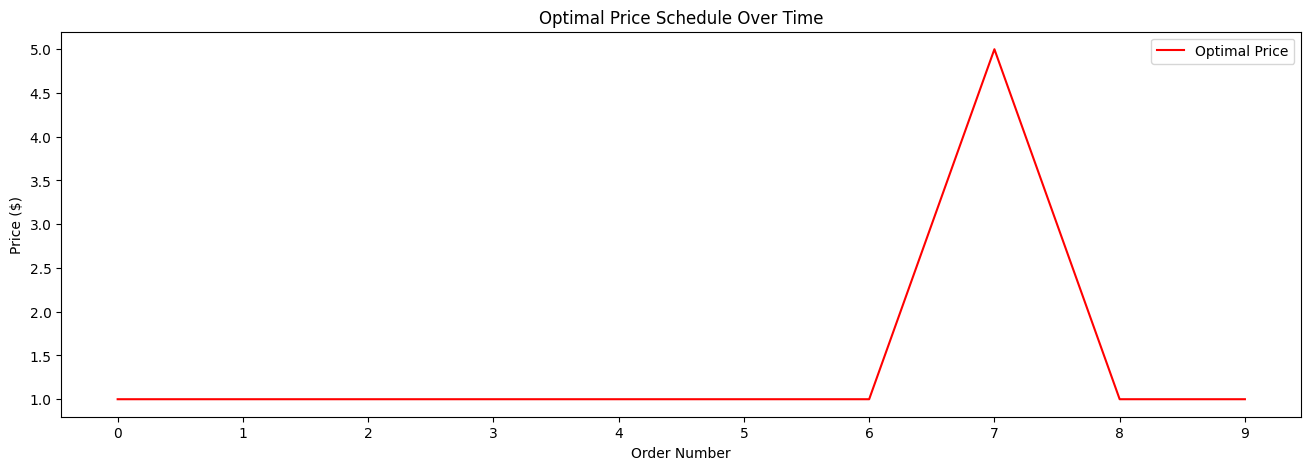

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def find_optimal_price_t(p_baseline, price_grid, t, product_id, user_id, orders_df, products_df, customers_df):
    """Finds the optimal price for time t (order number) using a greedy approach."""
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid

    user_orders_length = len(orders_df[orders_df['user_id'] == user_id])

    profits = []

    for p in p_grid:
        # Make sure the price array matches the user's order history length
        p_adjusted = np.resize(p, user_orders_length)  # Resize the price array if needed
        profit = profit_response(p_adjusted, orders_df, products_df, customers_df)

        profits.append(profit)

    return price_grid[np.argmax(np.array(profits))]





def find_optimal_price_schedule(T, price_grid, orders_df, products_df, customers_df):
    """Finds the optimal price schedule over T time steps (orders)."""


    user_orders_length = len(orders_df[orders_df['user_id'] == user_id])

    p_opt = np.repeat(price_opt_const, min(T,user_orders_length))  # Initialize with constant price, limit to user history.


    for t in range(min(T, user_orders_length)): # Iterate up to T or user's order history length, whichever is smaller
        p_opt[t] = find_optimal_price_t(p_opt, price_grid, t, product_id, user_id, orders_df, products_df, customers_df)
    return p_opt


# Example usage:
T = 10  # Number of time steps (can be more than available orders, will be capped)
price_opt_const = 2.0  # Initial constant price
price_grid = np.linspace(1.0, 5.0, 10)



p_opt = find_optimal_price_schedule(T, price_grid, orders, products, customers)

user_orders_length = len(orders[orders['user_id'] == user_id])

achieved_profit = profit_response(np.resize(p_opt, user_orders_length), orders, products, customers) # Resize price schedule to user's order length


print(f"Optimal price schedule: {p_opt}")
print(f"Achieved profit: {achieved_profit}")

# Plotting
plt.figure(figsize=(16, 5))
plt.title("Optimal Price Schedule Over Time")
plt.xlabel("Order Number")
plt.ylabel("Price ($)")


plt.xticks(np.arange(len(p_opt)))  # Set x-ticks according to the price schedule length
plt.plot(np.arange(len(p_opt)), p_opt, c='red', label="Optimal Price")



plt.legend()
plt.show()

In [ ]:
#Greedy Algorithm


Implementing Dynamic Pricing on the Instacart DataSet

In [ ]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition tuple for experience replay
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class OptimizedPricingDQN:
    def __init__(self, products_df, customers_df, all_orders,
                 price_grid=np.linspace(0.1, 2.0, 20),
                 num_episodes=10,
                 batch_size=128,
                 learning_rate=0.001):
        # Data preprocessing
        self.products = products_df
        self.customers = customers_df
        self.all_orders = all_orders

        # Environment parameters
        self.price_grid = price_grid
        self.T = len(all_orders['order_number'].unique())

        # Hyperparameters
        self.num_episodes = num_episodes
        self.batch_size = batch_size
        self.gamma = 0.99
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 200

        # Neural Network
        self.state_size = 2 * self.T
        self.action_size = len(self.price_grid)

        # Initialize networks
        self.policy_net = self._build_network().to(device)
        self.target_net = self._build_network().to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)

        # Replay Memory
        self.memory = ReplayMemory(10000)

        # Tracking
        self.return_trace = []
        self.price_trace = []

    def _build_network(self):
        return nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )

    def _demand_function(self, price, product_id, week_no, day_of_week, customer_segment):
      try:
        base_demand = self.products[self.products['product_id'] == product_id]['product_total_orders'].iloc[0] / self.T
        price_sensitivity = -0.5
        segment_multiplier = 1.0

        if customer_segment == 0:
            segment_multiplier = 0.8
        elif customer_segment == 6:
            segment_multiplier = 1.2

        demand = base_demand + price_sensitivity * price * segment_multiplier

        # Seasonality and weekend adjustments
        if 20 <= week_no <= 30:
            demand *= 1.2
        if day_of_week >= 5:
            demand *= 1.1
        return max(0, demand)
      except Exception as e:
        print(f"Error in demand function: {e}")
        return 0

    def _profit_calculation(self, price, product_id, week_no, day_of_week, customer_segment, unit_cost=0.5):
        demand = self._demand_function(price, product_id, week_no, day_of_week, customer_segment)
        return (price - unit_cost) * demand

    def train(self):
        for episode in range(self.num_episodes):
            product_id = self.products.sample(1)['product_id'].iloc[0]
            customer_segment = self.customers.sample(1)['favorite_day_of_week'].iloc[0]

            state = np.zeros(2 * self.T)
            total_reward = 0
            price_schedule = []

            for t in range(self.T):
                week_no = t + 1
                try:
                  day_of_week = self.all_orders[self.all_orders['order_number'] == week_no]['order_dow'].sample(1).iloc[0]
                except:
                  day_of_week = 0

                # Epsilon-greedy action selection
                eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * episode / self.eps_decay)
                if random.random() > eps_threshold:
                    with torch.no_grad():
                       state_tensor = torch.FloatTensor(state).to(device)
                       q_values = self.policy_net(state_tensor)
                       action = q_values.argmax().item()
                else:
                    action = random.randrange(len(self.price_grid))

                # Take action
                next_state = np.zeros_like(state)
                next_state[0] = self.price_grid[action]
                next_state[1:self.T] = state[0:self.T-1]
                next_state[self.T + t] = 1

                reward = self._profit_calculation(
                    next_state[0], product_id, week_no,
                    day_of_week, customer_segment
                )

                # Store transition
                self.memory.push(
                    torch.FloatTensor(state).to(device),
                    torch.tensor([action], dtype=torch.long).to(device),
                    torch.FloatTensor(next_state).to(device) if t != self.T - 1 else None,
                    torch.tensor([reward], dtype=torch.float).to(device)
                )

                state = next_state
                total_reward += reward
                price_schedule.append(self.price_grid[action])

                # Learn
                self._optimize_model()

            # Update tracking
            self.return_trace.append(total_reward)
            self.price_trace.append(price_schedule)

            # Periodic target network update
            if episode % 20 == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
                print(f'Episode {episode}/{self.num_episodes}')

        return self.return_trace, self.price_trace

    def _optimize_model(self):
      if len(self.memory) < self.batch_size:
            return

      transitions = self.memory.sample(self.batch_size)
      batch = Transition(*zip(*transitions))

        # Create tensors
      non_final_mask = torch.tensor(tuple(s is not None for s in batch.next_state), device=device, dtype=torch.bool)
      non_final_next_states = torch.stack([s for s in batch.next_state if s is not None]) if any(non_final_mask) else None

      state_batch = torch.stack(batch.state)
      action_batch = torch.stack(batch.action)
      reward_batch = torch.stack(batch.reward)

        # Compute Q values
      state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute next state values
      next_state_values = torch.zeros(self.batch_size, device=device)
      if non_final_next_states is not None:
          with torch.no_grad():
              next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        # Compute expected Q values
      expected_state_action_values = reward_batch.squeeze() + (self.gamma * next_state_values)

        # Compute Huber loss
      loss = F.smooth_l1_loss(state_action_values.squeeze(), expected_state_action_values)

        # Optimize the model
      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1)
      self.optimizer.step()

      # Memory management
      del transitions, batch, non_final_mask, non_final_next_states, state_batch, action_batch, reward_batch
      del state_action_values, next_state_values, expected_state_action_values
      torch.cuda.empty_cache()  # Clear GPU memory


class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
      if len(self.memory) < batch_size:
          return random.sample(self.memory, len(self.memory))
      return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Usage example
def plot_returns_and_prices(return_trace, price_trace):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot returns
    ax1.plot(return_trace)
    ax1.set_title('Episode Returns')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Return')

    # Plot price schedules
    ax2.boxplot(price_trace)
    ax2.set_title('Price Distribution')
    ax2.set_xlabel('Time Period')
    ax2.set_ylabel('Price')

    plt.tight_layout()
    plt.show()

# Main execution
def run_pricing_optimization(products, customers, all_orders):
    pricing_dqn = OptimizedPricingDQN(products, customers, all_orders)
    return_trace, price_trace = pricing_dqn.train()

    # Analyze results
    best_profits = []
    for price_schedule in price_trace[-10:]:
        try:
            product_id = products.sample(1)['product_id'].iloc[0]
            day_of_week = all_orders.sample(1)['order_dow'].iloc[0]
            customer_segment = customers.sample(1)['favorite_day_of_week'].iloc[0]


            # Calculate total profit for the entire price schedule
            total_profit = sum(
                pricing_dqn._profit_calculation(
                    price,
                    product_id,
                    week_no + 1,  # Assuming week numbers start from 1
                    day_of_week,
                    customer_segment
                )
                for week_no, price in enumerate(price_schedule)
            )

            best_profits.append(total_profit)
        except Exception as e:
            print(f"Error calculating profit for schedule: {e}")

        # Sort the calculated profits
        best_profits = sorted(best_profits)

        for profit in best_profits:
          print(f'Best profit results: {profit}')


# Assuming you have the dataframes: products, customers, all_orders from the previous script
run_pricing_optimization(products, customers, all_orders)
# Visualization
#plot_returns_and_prices(return_trace, price_trace)